In [181]:
import os
import math
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np
from IPython import display



Function to see folders

In [182]:
data_directory = '/content/drive/MyDrive/archive/Animals'

# Function to load categories from the dataset directory
def load_categories(data_dir):
    categories = os.listdir(data_dir)
    return categories



In [183]:
categories = load_categories(data_directory)
print("Categories (Folders) found in data directory:", categories)

Categories (Folders) found in data directory: ['Lion', 'Cheetah', 'Tiger', 'Jaguar', 'Leopard']


FUNCTION TO PREPARE TRAINING DATA

In [184]:
def prepare_training_data(categories, data_dir):
    training_data = []
    for category in categories:
        category_path = os.path.join(data_dir, category)

        for img in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            label = categories.index(category)
            img_path = os.path.join(category_path, img)

            try:
                # Read and process the image
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.resize(img_arr, (256, 256))
                training_data.append([img_arr, label])
            except Exception as e:
                pass  # Skip files that cannot be processed

    return training_data


In [185]:
training_data = prepare_training_data(categories, data_directory)

# Shuffle the data
random.shuffle(training_data)

Processing Leopard: 100%|██████████| 31/31 [00:00<00:00, 106.03it/s]


SEE 30 IMAGES


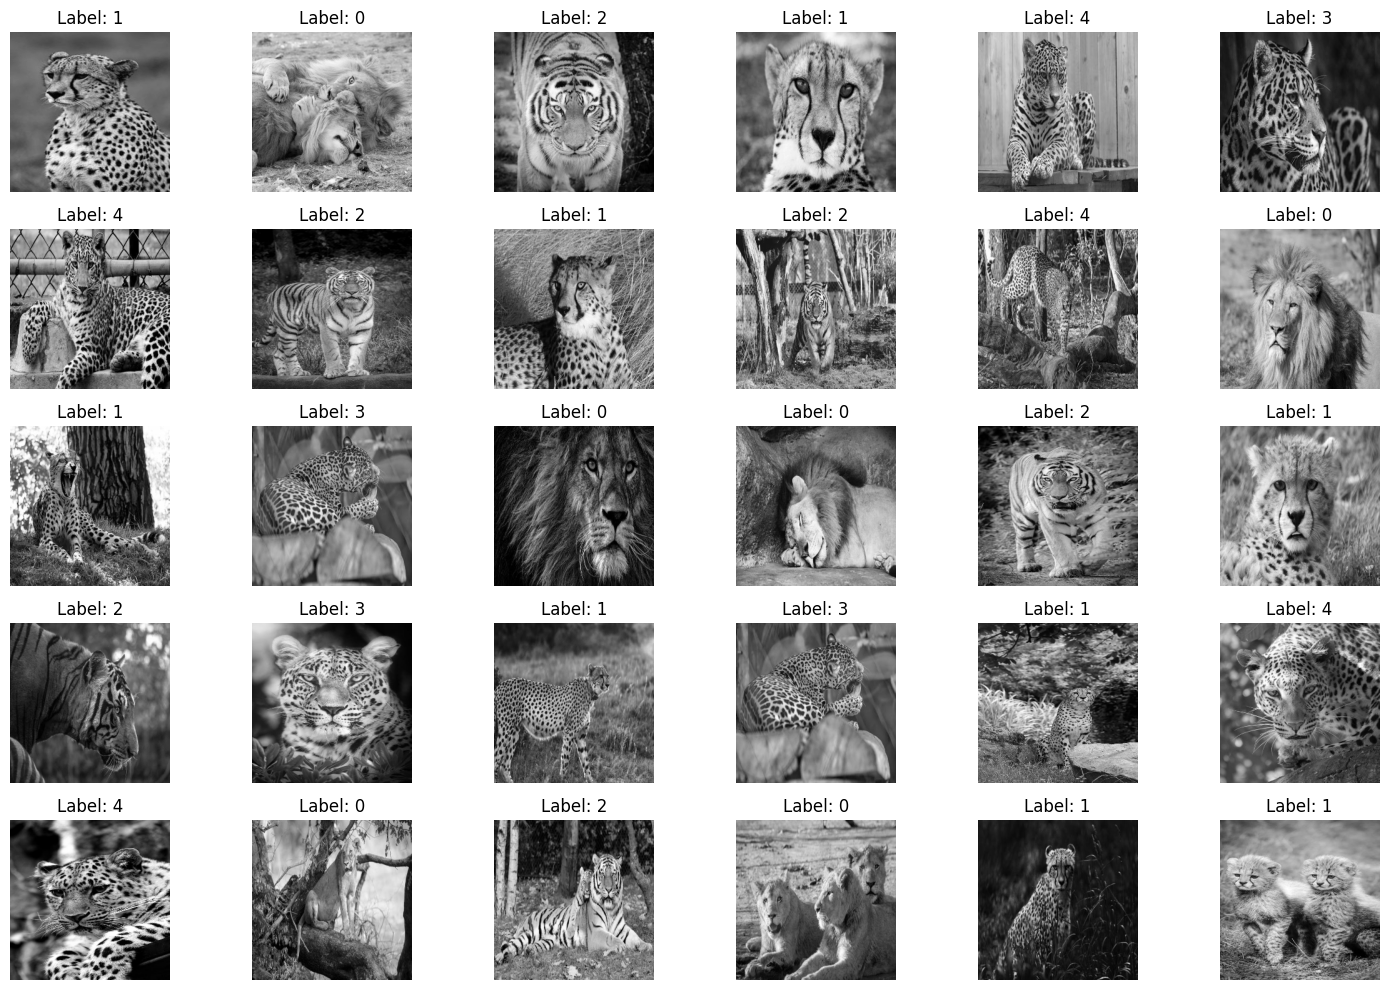

In [186]:


# Set up a grid to display 30 images (e.g., 5 rows x 6 columns)
plt.figure(figsize=(15, 10))

for i in range(30):
    plt.subplot(5, 6, i + 1)  # Arrange images in a 5x6 grid
    plt.imshow(training_data[i][0], cmap='gray')  # Display in grayscale
    plt.title(f"Label: {training_data[i][1]}")    # Show the label as title
    plt.axis('off')                               # Hide axes for a cleaner look

plt.tight_layout()
plt.show()


In [187]:
from sklearn.model_selection import KFold


# Convert the training data into separate arrays for features (X) and labels (y)
X = np.array([item[0] for item in training_data])  # Features (images)
y = np.array([item[1] for item in training_data])  # Labels



# Initialize KFold for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [188]:
# Loop through each fold to use it as the validation set
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Processing fold {fold + 1}/5")

    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    #  train model using X_train, y_train and evaluate using X_val, y_val
    # print the number of training and validation images for each fold
    print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")


Processing fold 1/5
Training set size: 136, Validation set size: 34
Processing fold 2/5
Training set size: 136, Validation set size: 34
Processing fold 3/5
Training set size: 136, Validation set size: 34
Processing fold 4/5
Training set size: 136, Validation set size: 34
Processing fold 5/5
Training set size: 136, Validation set size: 34


FUNCTION TO CALCULATE EUCLIDEAN DISTANCE

In [189]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

FUNCTION TO CALCULATE distance for each valid. image

In [190]:
# Initialize a list to store distances for each validation image
precomputed_distances = []

# Loop through each validation image
for val_img in X_val:
    distances = []

    # Flatten the validation image to 1D vector for distance computation
    val_img_flattened = val_img.flatten()

    # Calculate distance to each training image
    for train_img, train_label in zip(X_train, y_train):
        # Flatten training images to 1D vector
        train_img_flattened = train_img.flatten()

        # Calculate Euclidean distance between the validation image and the training image
        dist = euclidean_distance(val_img_flattened, train_img_flattened)
        distances.append((dist, train_label))  # Store distance along with the label

    # Sort distances by the distance value
    distances.sort(key=lambda x: x[0])

    # Append the sorted distances to the list
    precomputed_distances.append(distances)

# Now, 'precomputed_distances' contains all the distances for future use


In [191]:
from collections import Counter


# Function to get the most common label among K nearest neighbors
def get_most_common_label(neighbors_labels):
    return Counter(neighbors_labels).most_common(1)[0][0]

In [192]:
# Initialize results dictionary to store accuracy for each K value for each fold
results = {k: [] for k in range(1, 31)}

In [193]:

# Loop through each fold from KFold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nProcessing Fold {fold + 1}/5")

    # Split the data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Now calculate accuracy for each K value using precomputed distances
    for k in range(1, 31):
        correct_predictions = 0  # To count correct predictions for this K value

        # Loop through each validation image and its corresponding sorted distances
        for val_idx, distances in enumerate(precomputed_distances):
            # Get the K nearest neighbors
            k_nearest_labels = [label for _, label in distances[:k]]

            # Find the most common label among the K nearest neighbors
            predicted_label = Counter(k_nearest_labels).most_common(1)[0][0]

            # Get the true label of the validation image
            true_label = y_val[val_idx]

            # Check if the prediction is correct
            if predicted_label == true_label:
                correct_predictions += 1

        # Calculate accuracy for this K value
        fold_accuracy = correct_predictions / len(y_val)

        # Store the accuracy in the results dictionary
        results[k].append(fold_accuracy)

        print(f"Fold {fold + 1}, K={k}, Accuracy={fold_accuracy:.4f}")






Processing Fold 1/5
Fold 1, K=1, Accuracy=0.1471
Fold 1, K=2, Accuracy=0.1471
Fold 1, K=3, Accuracy=0.1176
Fold 1, K=4, Accuracy=0.1471
Fold 1, K=5, Accuracy=0.1471
Fold 1, K=6, Accuracy=0.1765
Fold 1, K=7, Accuracy=0.1765
Fold 1, K=8, Accuracy=0.2059
Fold 1, K=9, Accuracy=0.0882
Fold 1, K=10, Accuracy=0.1176
Fold 1, K=11, Accuracy=0.1176
Fold 1, K=12, Accuracy=0.1176
Fold 1, K=13, Accuracy=0.1471
Fold 1, K=14, Accuracy=0.1176
Fold 1, K=15, Accuracy=0.1471
Fold 1, K=16, Accuracy=0.1765
Fold 1, K=17, Accuracy=0.1765
Fold 1, K=18, Accuracy=0.1765
Fold 1, K=19, Accuracy=0.2353
Fold 1, K=20, Accuracy=0.2647
Fold 1, K=21, Accuracy=0.2647
Fold 1, K=22, Accuracy=0.2647
Fold 1, K=23, Accuracy=0.2647
Fold 1, K=24, Accuracy=0.3235
Fold 1, K=25, Accuracy=0.2941
Fold 1, K=26, Accuracy=0.2059
Fold 1, K=27, Accuracy=0.1765
Fold 1, K=28, Accuracy=0.1765
Fold 1, K=29, Accuracy=0.2353
Fold 1, K=30, Accuracy=0.1765

Processing Fold 2/5
Fold 2, K=1, Accuracy=0.2059
Fold 2, K=2, Accuracy=0.2059
Fold 2, K

In [194]:


# Calculate the average accuracy for each K value across the 5 folds
average_accuracies = {k: np.mean(acc) for k, acc in results.items()}

# Print the average accuracy for each K value
print("\nAverage Accuracy for Each K Value across 5 Folds:")
for k in range(1, 31):
    avg_acc = average_accuracies[k]  # Get average accuracy for this K
    print(f"For K={k}, avg accuracy across 5 folds = {avg_acc:.4f}")



Average Accuracy for Each K Value across 5 Folds:
For K=1, avg accuracy across 5 folds = 0.2412
For K=2, avg accuracy across 5 folds = 0.2412
For K=3, avg accuracy across 5 folds = 0.2294
For K=4, avg accuracy across 5 folds = 0.2765
For K=5, avg accuracy across 5 folds = 0.2471
For K=6, avg accuracy across 5 folds = 0.2647
For K=7, avg accuracy across 5 folds = 0.2471
For K=8, avg accuracy across 5 folds = 0.2824
For K=9, avg accuracy across 5 folds = 0.2118
For K=10, avg accuracy across 5 folds = 0.1824
For K=11, avg accuracy across 5 folds = 0.1882
For K=12, avg accuracy across 5 folds = 0.1941
For K=13, avg accuracy across 5 folds = 0.2412
For K=14, avg accuracy across 5 folds = 0.2529
For K=15, avg accuracy across 5 folds = 0.2471
For K=16, avg accuracy across 5 folds = 0.2353
For K=17, avg accuracy across 5 folds = 0.2176
For K=18, avg accuracy across 5 folds = 0.2059
For K=19, avg accuracy across 5 folds = 0.2235
For K=20, avg accuracy across 5 folds = 0.2588
For K=21, avg accu

In [195]:


# Calculate the centroid (mean) of the accuracies for each K value across 5 folds
centroids = {k: np.mean(acc) for k, acc in results.items()}

# Print the centroid for each K value
print("\nCentroid (Mean Accuracy) for Each K Value across 5 Folds:")
for k in range(1, 31):
    centroid = centroids[k]  # Get the centroid (mean accuracy) for this K
    print(f"For K={k}, centroid of accuracies = {centroid:.4f}")



Centroid (Mean Accuracy) for Each K Value across 5 Folds:
For K=1, centroid of accuracies = 0.2412
For K=2, centroid of accuracies = 0.2412
For K=3, centroid of accuracies = 0.2294
For K=4, centroid of accuracies = 0.2765
For K=5, centroid of accuracies = 0.2471
For K=6, centroid of accuracies = 0.2647
For K=7, centroid of accuracies = 0.2471
For K=8, centroid of accuracies = 0.2824
For K=9, centroid of accuracies = 0.2118
For K=10, centroid of accuracies = 0.1824
For K=11, centroid of accuracies = 0.1882
For K=12, centroid of accuracies = 0.1941
For K=13, centroid of accuracies = 0.2412
For K=14, centroid of accuracies = 0.2529
For K=15, centroid of accuracies = 0.2471
For K=16, centroid of accuracies = 0.2353
For K=17, centroid of accuracies = 0.2176
For K=18, centroid of accuracies = 0.2059
For K=19, centroid of accuracies = 0.2235
For K=20, centroid of accuracies = 0.2588
For K=21, centroid of accuracies = 0.2471
For K=22, centroid of accuracies = 0.2353
For K=23, centroid of accu

In [196]:
 #Extract K values and corresponding average accuracies
k_values = list(average_accuracies.keys())
centroids = list(average_accuracies.values())

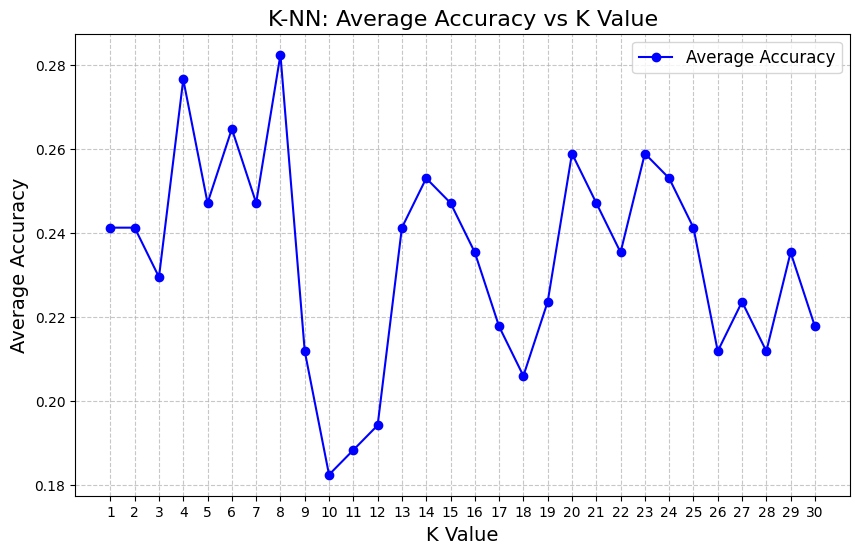

In [197]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, centroids, marker='o', linestyle='-', color='b', label='Average Accuracy')

# Add labels, title, and grid
plt.xlabel("K Value", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.title("K-NN: Average Accuracy vs K Value", fontsize=16)
plt.xticks(k_values)  # Mark all K values on the x-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()